In [1]:
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from src.lrg_eegfc import *

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### Data loading

In [2]:
data_dict, int_label_pos_map = load_data_dict(mat_path, patients_list, phase_labels, param_keys_list)

### Per Patient, phase snapshots

In [3]:
patient = 'Pat_02'
phase = 'rsPre'
#
corr_net_filt = dict(threshold=0)
#
data_pat_phase = data_dict[patient][phase]
data_pat_phase_ts = data_pat_phase['data']
fs = data_pat_phase['fs']
filter_order = data_pat_phase['filter_order']
#
n_intervals = 100
interval_length = int(data_pat_phase_ts.shape[1] // n_intervals)
n_intervals, interval_length

(100, 13232)

In [4]:
corr_mat_band_tw = {}
for band_name, (low, high) in tqdm(BRAIN_BANDS.items()):
    corr_mat_band_tw[band_name] = {}
    for i in range(n_intervals):
        start = i * interval_length
        end = (i + 1) * interval_length
        interval_data = data_pat_phase_ts[:, start:end]
        filter_data = bandpass_sos(interval_data, low, high, fs, filter_order)
        corr_mat = build_corr_network(filter_data, **corr_net_filt)
        corr_mat_band_tw[band_name][i] = corr_mat

  0%|          | 0/6 [00:00<?, ?it/s]/home/opisthofulax/anaconda3/envs/lapbrain/lib/python3.12/site-packages/scipy/signal/_filter_design.py:4334: RuntimeWarning: overflow encountered in scalar negative
  m = numpy.arange(-N+1, N, 2)
100%|██████████| 6/6 [00:19<00:00,  3.23s/it]


In [5]:
corr_nets = {band_name: {i: nx.from_numpy_array(corr_mat_band_tw[band_name][i]) for i in range(n_intervals)} for band_name, (low, high) in tqdm(BRAIN_BANDS.items())}

corr_nets_th = {band_name: {i: threshold_graph(G0, 0.9) for i, G0 in corr_nets[band_name].items()} for band_name in corr_nets.keys()}
clear_output()

In [6]:
# 1. collect your data pairs (t1, dS1) for each time step into a list
data_list = []
for i, arr in corr_nets_th['delta'].items():
    Gcc, _ = get_giant_component_leftoff(arr[1])
    _, dS1, _, t1 = entropy(Gcc)
    data_list.append((t1[1:], dS1))

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:91: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:91: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


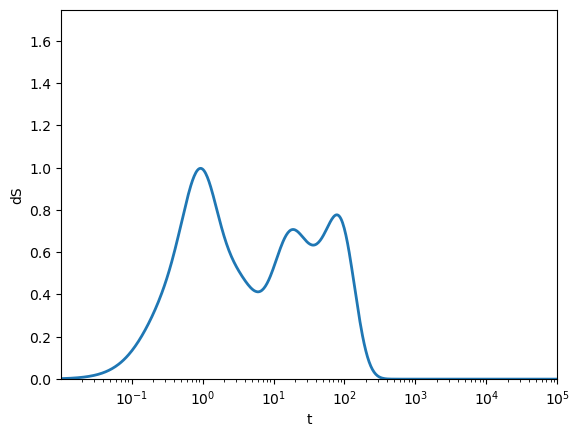

In [7]:
# 2. define a common abscissa on log‐scale
t_grid = np.unique(np.concatenate([t for t, _ in data_list]))
t_log = np.log(t_grid)

# 3. interpolate all curves onto t_grid
dS_interp = []
for t, dS in data_list:
    x = np.log(t)
    y = dS
    dS_interp.append(np.interp(t_log, x, y))

# 4. build intermediate frames for smooth transitions
M = 10  # number of sub‐frames between each pair
frames = []
for k in range(len(dS_interp) - 1):
    a = dS_interp[k]
    b = dS_interp[k+1]
    for m in range(M):
        alpha = m / M
        frames.append((1 - alpha) * a + alpha * b)
frames.append(dS_interp[-1])  # final frame

# 5. set up figure and line object
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xscale('log')
ax.set_xlim(t_grid.min(), t_grid.max())
ax.set_ylim(np.min(dS_interp), np.max(dS_interp))
ax.set_xlabel('t')
ax.set_ylabel('dS')

# 6. animation update
def update(frame_data):
    line.set_data(t_grid, frame_data)
    return (line,)

ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=True)

# 7. save
ani.save('entropy_evolution.mp4', writer='ffmpeg', fps=10)